In [114]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Transformer

from torch.utils.data import DataLoader, Dataset, TensorDataset

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [117]:
train_features=torch.load('/content/drive/MyDrive/Colab Notebooks/KaggleProject/Code/train_features.pt')
train_labels=torch.load('/content/drive/MyDrive/Colab Notebooks/KaggleProject/Code/train_labels.pt')

In [118]:
print(train_features.shape)
print(train_labels.shape)

torch.Size([1704759, 14])
torch.Size([1704759])


In [119]:
train = torch.cat([train_features, train_labels.reshape(-1,1)],1)
print(train.shape)
train = train[torch.randperm(train.size(0))] #shuffling dataset, parameter down need to be updated
train_set = train[0:1500000,                            0:train.shape[1]-1]
train_label = train[0:1500000,                          train.shape[1]-1]
validation_set = train[1500000:1600000,                 0:train.shape[1]-1]
validation_label = train[1500000:1600000,               train.shape[1]-1]
test_set = train[1600000:train.shape[0],                0:train.shape[1]-1]
test_label = train[1600000:train.shape[0],              train.shape[1]-1]

torch.Size([1704759, 15])


In [120]:
print(test_set.shape)

torch.Size([104759, 14])


In [121]:
#You may save them if you want
torch.save(train_set,'/content/drive/MyDrive/Colab Notebooks/KaggleProject/Code/train_set.pt')
torch.save(train_label,'/content/drive/MyDrive/Colab Notebooks/KaggleProject/Code/train_label.pt')
torch.save(validation_set,'/content/drive/MyDrive/Colab Notebooks/KaggleProject/Code/validation_set.pt')
torch.save(validation_label,'/content/drive/MyDrive/Colab Notebooks/KaggleProject/Code/validation_label.pt')
torch.save(test_set,'/content/drive/MyDrive/Colab Notebooks/KaggleProject/Code/test_set.pt')
torch.save(test_label,'/content/drive/MyDrive/Colab Notebooks/KaggleProject/Code/test_label.pt')

In [122]:
del train_features
del train_labels

In [123]:
print(train_set.dtype)
print(train_label.dtype)

torch.float32
torch.float32


In [124]:
#I implement a MLP first, it is actually a Linear Regression
import torch.nn as nn
import torch.nn.functional as F


# class MLP(nn.Module):
#     def __init__(self, input_features):
#         super(MLP, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Linear(in_features=input_features,out_features=1)
#         )
        

#     def forward(self, x):
#         x=x.to(torch.float32)
#         x=self.layer1(x)
#         return x


class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, nhead, drop_prob=0.2):
        super(TransformerModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer, num_layers=n_layers)
        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x)
        return x





In [125]:
feature_size = 14  # your input feature size
hidden_dim = 50  # hidden dimensions
num_layers = 2  # number of transformer layers

# model = MLP(train_set.shape[1])
model = TransformerModel(input_dim=14, hidden_dim=128, output_dim=1, n_layers=2, nhead=2).to(device)

model = model.to(device)






In [126]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [127]:
import torch.optim as optim
learning_rate = 0.001
criterion = nn.MSELoss()
num_epochs = 10
BATCH_SIZE = 64

In [128]:
train_dataset = TensorDataset(train_set, train_label)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_loader))
all_losses = []

23438


In [129]:
# def train(model, train_loader,criterion,num_epochs):
#     optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate,weight_decay=1e-4)
#     for epoch in range(num_epochs):
#         epoch_loss = 0
#         group_320_loss = 0
#         for i,(x, y) in enumerate(train_loader,0):
#             x = x.to(device)
#             y = y.to(device)
#             y = torch.reshape(y,(-1,1))
#             optimizer.zero_grad()
#             output = model(x)
#             loss = torch.sqrt(criterion(output, y))#RMSE
#             epoch_loss += loss
#             loss.backward()
#             optimizer.step()
#             group_320_loss += loss
#             if i%30==29:
#                 all_losses.append(group_320_loss/6)
#         print(f"Epoch: {epoch+1} Loss:{epoch_loss/len(train_loader)*5}") #Want to get the loss of a set of 320
#         #all_losses.append(epoch_loss / len(train_loader))

def train(model, train_loader, criterion, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = torch.sqrt(criterion(output.squeeze(), y))  # RMSE
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f'Epoch: {epoch+1}, Loss: {epoch_loss / len(train_loader)}')
        all_losses.append(epoch_loss / len(train_loader))



In [131]:
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Adam optimizer
train(model, train_loader,criterion, num_epochs=10)

Epoch: 1, Loss: 588.5875853789078
Epoch: 2, Loss: 579.9480611939654
Epoch: 3, Loss: 579.6540839381364
Epoch: 4, Loss: 579.9076674886404
Epoch: 5, Loss: 578.3863818730721
Epoch: 6, Loss: 572.941564003145
Epoch: 7, Loss: 572.1309488867623
Epoch: 8, Loss: 571.4947886495869
Epoch: 9, Loss: 570.9802906808821
Epoch: 10, Loss: 570.73919289201


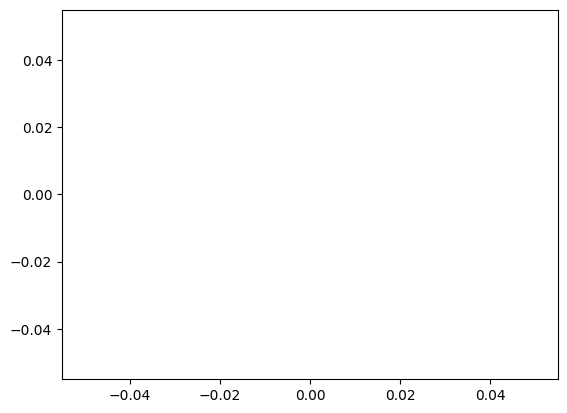

In [132]:
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(all_losses)))

In [133]:
del all_losses

In [134]:
def view_loss(model, test_set, test_label,criterion):
    total_loss=0
    test_dataset = TensorDataset(test_set, test_label)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y = torch.reshape(y,(-1,1))
        output = model(x)
        loss = torch.sqrt(criterion(output, y))#RMSE
        total_loss += loss
    return total_loss

In [135]:
#You need to see loss for validation set to tune the parameter. I didn't do that because linear regression is too simple

In [136]:
print(view_loss(model, test_set, test_label,criterion)/test_set.shape[0]*320)

tensor(2886.6038, device='cuda:0', grad_fn=<MulBackward0>)


In [137]:
predict_input = torch.load('/content/drive/MyDrive/Colab Notebooks/KaggleProject/Code/predict_input.pt').to(device)
print(predict_input.shape)

torch.Size([320, 14])


In [140]:
def predict(model):
    predict_output = model(predict_input.to(torch.float32))  # Convert predict_input to float32
    return predict_output

In [142]:
out = predict(model)
print(out)

tensor([[645.7317],
        [691.1990],
        [594.3899],
        [619.9306],
        [713.7745],
        [699.7175],
        [680.8671],
        [697.6458],
        [685.8085],
        [665.9501],
        [642.7405],
        [699.3496],
        [691.1123],
        [677.7203],
        [593.2997],
        [654.0855],
        [693.1206],
        [659.3746],
        [721.0643],
        [679.5562],
        [644.4718],
        [632.5269],
        [621.1812],
        [647.2720],
        [665.5930],
        [661.8324],
        [624.2960],
        [675.6755],
        [604.0149],
        [694.4103],
        [620.6193],
        [603.8240],
        [676.1353],
        [601.8138],
        [655.6996],
        [677.4210],
        [719.9491],
        [639.2413],
        [615.0406],
        [683.3306],
        [666.5973],
        [728.1533],
        [655.2395],
        [650.2361],
        [658.0184],
        [639.8054],
        [691.2067],
        [637.5101],
        [639.7264],
        [627.5450],


In [143]:
linear_predict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KaggleProject/ucsd-cse-151b-class-competition/archive/test_public.csv')
linear_predict = linear_predict['TRIP_ID']
predict_tensor = out.to('cpu').detach().numpy().flatten()
linear_predict= pd.concat([linear_predict, pd.DataFrame(predict_tensor)], axis=1)
linear_predict = linear_predict.rename(columns={0: 'TRAVEL_TIME'})
linear_predict.head()

,TRIP_ID,TRAVEL_TIME
0,T1,645.731689
1,T2,691.198975
2,T3,594.389893
3,T4,619.930603
4,T5,713.774536


In [144]:
linear_predict.to_csv('/content/drive/MyDrive/Colab Notebooks/KaggleProject/Code/linear_predict.csv', index=False)

In [145]:
PATH = 'linear.pth'
torch.save(model.state_dict(),PATH)

In [146]:
model = MLP(14).to(device)
model_state = torch.load('linear.pth')
model.load_state_dict(model_state)

TypeError: ignored

In [ ]:
#Use sklearn for something like gradient boosting or random forest

#Model Selection: Gradient Boosting,Random Forest,Extra Randomized Trees, SVM, Linear Regression, Logistic Regression, Neural Networks

In [ ]:
#TODO: build other models
#TODO: report loss on validation sets and tune parameters for each model
#TODO: run on test sets and report test loss
#TODO: predict travel time(test_features) and submit to kaggle